In [1]:
# This code works in Python 3.10.6
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import torch_geometric.utils.convert
import random
import dgl
import torch
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
import seaborn as sns
import glob

import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
import import_ipynb
#PubMed dataset with all features
import pubmed_dataset

importing Jupyter notebook from pubmed_dataset.ipynb
HeteroData(
  disease={
    x=[454, 200],
    y=[454],
  },
  gene={ x=[13561, 200] },
  chemical={ x=[26522, 200] },
  species={ x=[2863, 200] },
  (gene, to, gene)={ edge_index=[2, 40] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 70] },
  (chemical, to, chemical)={ edge_index=[2, 108] },
  (chemical, to, species)={ edge_index=[2, 18] },
  (species, to, gene)={ edge_index=[2, 6] }
)


In [3]:
data = pubmed_dataset.data

In [4]:
dataset = data.clone()
# Node features are removed as a temporary fix to the errors in conversion of 
#Pytorch Geometric HeteroData to DGL graph. Node features are not important for creating metagraph.
dataset['disease'].x = dataset['disease'].x[:405, :]
dataset['disease'].y = dataset['disease'].y[:405]
dataset['gene'].x = dataset['gene'].x[:13499, :]
dataset['chemical'].x = dataset['chemical'].x[:26406, :]
dataset['species'].x = dataset['species'].x[:2741, :]

In [5]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(dataset)
meta_g= g.metagraph()

Feature selection

In [6]:
disease_df = pd.DataFrame(data['disease'].x.numpy())
corr = disease_df.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.31).any()
real = corr.loc[m]
list_index = np.ravel(real.index).tolist()
imp_feat_disease = disease_df[list_index]
imp_feat_disease.head()

,21,93,101,102,113,132,157,168,184,195
0,-0.049199,-0.661063,-0.575829,-0.654472,-0.380207,-0.607926,-0.806685,-1.668898,0.394494,-0.147028
1,-0.010990,0.015168,0.081877,-0.099833,-0.106269,0.028642,-0.039650,-0.074852,0.019654,0.027611
2,0.024383,-0.002340,-0.096183,-0.645202,-0.583847,-0.149890,0.489459,0.153196,0.059728,0.468901
3,1.980411,0.900365,-0.132044,0.542163,0.822428,1.078119,-0.320361,-1.235528,-0.523441,-0.957820
4,0.022329,0.005585,-0.037312,-0.096791,-0.041126,0.066148,0.025007,0.008063,-0.061589,0.033324


In [7]:
gene_df = pd.DataFrame(data['gene'].x.numpy())
corr = gene_df.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.3).any()#25
real = corr.loc[m]
list_index = np.ravel(real.index).tolist()
imp_feat_gene = gene_df[list_index]
imp_feat_gene.head()

,10,18,20,22,30,39,43,45,50,67,...,158,166,170,177,180,187,189,191,197,198
0,-0.704017,0.339762,1.045337,-0.077692,-0.704528,-0.743278,-0.322248,0.191509,0.036557,0.093054,...,-0.614628,0.243493,-0.281078,0.763508,0.039372,-0.754213,-0.400457,1.225612,-0.537381,-0.201888
1,-0.093181,-0.108622,-0.051060,-0.001862,0.031795,0.012587,-0.237211,-0.031764,-0.045257,-0.103915,...,0.002832,0.012780,-0.036292,0.109502,0.159995,0.057054,0.092252,-0.002954,-0.093537,0.058352
2,0.048942,-0.032381,0.025348,0.046628,-0.132375,0.014892,-0.001030,-0.004722,0.008070,0.025992,...,0.049146,-0.066684,-0.058503,-0.087881,0.020343,0.069552,-0.035792,-0.028505,0.133960,-0.005101
3,-0.088893,-0.123888,-0.122054,0.095008,0.021393,0.078796,-0.098809,0.044173,0.023765,-0.002153,...,-0.153651,-0.011099,-0.159795,0.125775,0.100356,0.096066,0.018544,-0.063992,-0.030979,-0.105407
4,-0.027507,-0.043604,0.016110,-0.007765,-0.014601,0.047154,-0.089594,0.013862,-0.057354,-0.059267,...,0.034145,-0.110786,-0.068164,0.134944,0.037677,0.115986,0.015607,-0.052860,0.062609,-0.053292


In [8]:
chemical_df = pd.DataFrame(data['chemical'].x.numpy())
corr = chemical_df.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.25).any() #2
real = corr.loc[m]
list_index = np.ravel(real.index).tolist()
imp_feat_chemical = chemical_df[list_index]
imp_feat_chemical.head()

,0,9,21,22,27,31,32,47,48,50,...,148,152,155,165,166,186,187,196,198,199
0,0.025080,0.014751,-0.104169,0.009346,0.057331,-0.077084,-0.146175,-0.022848,-0.026000,-0.007367,...,-0.073615,-0.006019,-0.027909,0.020149,-0.044378,0.080353,0.024683,-0.082280,-0.235815,0.148486
1,-0.072251,0.029246,0.046273,0.060928,0.060762,-0.007616,-0.081318,0.023882,0.014597,-0.004101,...,0.051121,0.068302,-0.034247,0.037715,-0.083038,0.042857,0.045365,-0.096253,-0.084090,0.112620
2,-0.100137,0.055137,-0.001090,0.073477,0.042279,0.071881,-0.107358,-0.108142,0.198319,0.060645,...,0.007965,0.070457,-0.055622,0.113822,-0.086742,-0.010452,0.006794,-0.168877,-0.139757,0.188840
3,0.005788,0.038040,0.022279,0.022396,-0.006780,-0.037123,0.008749,-0.008209,0.124028,-0.031227,...,-0.024766,0.003531,-0.045464,0.070007,-0.000117,-0.013096,0.002987,-0.084280,-0.004936,-0.012823
4,-0.383792,-0.437774,-0.091600,0.076947,0.298811,-0.023874,-0.037989,0.494877,-1.082428,0.067377,...,0.417890,0.323766,-0.059161,-0.098438,0.065616,0.108233,0.426201,-0.427307,-0.135551,0.229372


In [9]:
species_df = pd.DataFrame(data['species'].x.numpy())
corr = species_df.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.38).any() #3
real = corr.loc[m]
list_index = np.ravel(real.index).tolist()
imp_feat_species = species_df[list_index]
imp_feat_species.head()

,0,6,7,11,12,15,19,29,31,43,...,142,151,158,160,163,172,186,190,191,195
0,-0.095541,-0.119118,0.127669,0.184534,-0.315813,-0.041035,0.031233,-0.123522,0.138827,-0.207318,...,-0.073226,-0.006500,0.128403,-0.283128,-0.073810,0.070506,-0.090439,-0.202548,-0.169779,0.158141
1,0.030015,0.058275,0.146817,0.497685,-0.332718,0.119033,-0.131531,0.209554,-0.033554,-0.353803,...,-0.119124,-0.135668,-0.039328,0.124373,-0.201092,-0.035319,0.072580,-0.099218,0.021566,0.302752
2,-0.093925,-0.081715,-0.095580,0.128428,-0.237412,0.027049,0.052257,0.187015,-0.006711,-0.024341,...,-0.185094,-0.120684,0.237681,-0.209625,0.117584,0.115637,-0.158314,-0.309859,-0.049366,0.159422
3,-0.014923,-0.010118,0.059465,0.067057,-0.065833,-0.000504,-0.032947,-0.021795,0.003368,-0.074209,...,-0.008632,-0.011347,0.036791,0.009016,-0.057370,-0.013681,0.051281,-0.022425,-0.016115,0.027601
4,-0.174262,-0.015600,0.162443,0.145996,-0.085919,-0.021072,0.184825,-0.015868,-0.107737,-0.122362,...,-0.014203,0.115470,0.148917,-0.012893,0.048776,0.136452,0.054193,0.061785,0.007814,0.061030


In [10]:
data['gene'].x = torch.tensor(imp_feat_gene.values).to(dtype=torch.float32)
data['disease'].x = torch.tensor(imp_feat_disease.values).to(dtype=torch.float32)
data['chemical'].x = torch.tensor(imp_feat_chemical.values).to(dtype=torch.float32)
data['species'].x = torch.tensor(imp_feat_species.values).to(dtype=torch.float32)

In [11]:
#PubMed dataset with selected features used for GNN training
data

HeteroData(
  disease={
    x=[454, 10],
    y=[454],
  },
  gene={ x=[13561, 44] },
  chemical={ x=[26522, 33] },
  species={ x=[2863, 41] },
  (gene, to, gene)={ edge_index=[2, 40] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 70] },
  (chemical, to, chemical)={ edge_index=[2, 108] },
  (chemical, to, species)={ edge_index=[2, 18] },
  (species, to, gene)={ edge_index=[2, 6] }
)

Train PubMed

In [12]:
transform = T.RandomNodeSplit(split='train_rest', num_val=0.15, num_test=0.15)
data = transform(data)
data

HeteroData(
  disease={
    x=[454, 10],
    y=[454],
    train_mask=[454],
    val_mask=[454],
    test_mask=[454],
  },
  gene={ x=[13561, 44] },
  chemical={ x=[26522, 33] },
  species={ x=[2863, 41] },
  (gene, to, gene)={ edge_index=[2, 40] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 70] },
  (chemical, to, chemical)={ edge_index=[2, 108] },
  (chemical, to, species)={ edge_index=[2, 18] },
  (species, to, gene)={ edge_index=[2, 6] }
)

In [13]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['disease'])


model = HeteroGNN(data.metadata(), hidden_channels=256, out_channels=8,
                  num_layers=4)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['disease'].train_mask
    loss = F.cross_entropy(out[mask], data['disease'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['disease'][split]
        acc = (pred[mask] == data['disease'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 501):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 010, Loss: 1.7222, Train: 0.3711, Val: 0.3529, Test: 0.2353
Epoch: 020, Loss: 1.2700, Train: 0.5377, Val: 0.3529, Test: 0.2353
Epoch: 030, Loss: 1.0312, Train: 0.6572, Val: 0.3088, Test: 0.2353
Epoch: 040, Loss: 0.7390, Train: 0.7484, Val: 0.3088, Test: 0.2794
Epoch: 050, Loss: 0.5000, Train: 0.8302, Val: 0.2647, Test: 0.1912
Epoch: 060, Loss: 0.6244, Train: 0.8113, Val: 0.3088, Test: 0.2941
Epoch: 070, Loss: 0.4504, Train: 0.8742, Val: 0.3235, Test: 0.2206
Epoch: 080, Loss: 0.3122, Train: 0.9057, Val: 0.3088, Test: 0.2206
Epoch: 090, Loss: 0.2229, Train: 0.9340, Val: 0.2941, Test: 0.2059
Epoch: 100, Loss: 0.2016, Train: 0.9403, Val: 0.3088, Test: 0.2500
Epoch: 110, Loss: 0.1260, Train: 0.9748, Val: 0.2794, Test: 0.2206
Epoch: 120, Loss: 0.0900, Train: 0.9874, Val: 0.2647, Test: 0.2059
Epoch: 130, Loss: 0.0665, Train: 0.9937, Val: 0.2500, Test: 0.1765
Epoch: 140, Loss: 0.0506, Train: 1.0000, Val: 0.2647, Test: 0.1765
Epoch: 150, Loss: 0.0406, Train: 1.0000, Val: 0.2941, Test: 0.

In [14]:
def apply_threshold(df):
    return df.applymap(lambda x: random.uniform(-1.0, 0.0) if x == 0.0 else random.uniform(0.1, 1.0))

In [15]:
#Reading from file the generated node features using diffusion
class_path = '../sampled_features/pubmed'
class0  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features0.pt').cpu().numpy()))
class1  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features1.pt').cpu().numpy()))
class2  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features2.pt').cpu().numpy()))
class3  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features3.pt').cpu().numpy()))
class4  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features4.pt').cpu().numpy()))
class5  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features5.pt').cpu().numpy()))
class6  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features6.pt').cpu().numpy()))
class7  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features7.pt').cpu().numpy()))

# gene  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features6_gene.pt')[0].cpu().numpy()))
# chemical  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features5_chemical.pt')[0].cpu().numpy()))
# species  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features6_species.pt').cpu().numpy()))

gene  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features44_gene.pt')[0].cpu().numpy()))
chemical  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features33_chemical.pt')[0].cpu().numpy()))
species  = apply_threshold(pd.DataFrame(torch.load(class_path + '/features41_species.pt')[0].cpu().numpy()))

df_class0 = class0.drop(class0[class0.sum(axis=1)==0.0].index)
df_class0=df_class0.reset_index(drop=True)

df_class1 = class1.drop(class1[class1.sum(axis=1)==0.0].index)
df_class1=df_class1.reset_index(drop=True)

df_class2 = class2.drop(class2[class2.sum(axis=1)==0.0].index)
df_class2=df_class2.reset_index(drop=True)

df_class3 = class3.drop(class3[class3.sum(axis=1)==0.0].index)
df_class3=df_class3.reset_index(drop=True)

df_class4 = class4.drop(class3[class4.sum(axis=1)==0.0].index)
df_class4=df_class4.reset_index(drop=True)

df_class5 = class5.drop(class5[class5.sum(axis=1)==0.0].index)
df_class5=df_class5.reset_index(drop=True)

df_class6 = class6.drop(class6[class6.sum(axis=1)==0.0].index)
df_class6=df_class6.reset_index(drop=True)

df_class7 = class7.drop(class7[class7.sum(axis=1)==0.0].index)
df_class7=df_class7.reset_index(drop=True)


def get_node_features(G):
    nodes = []
    gene_node_features = []
    disease_node_features = []
    disease_class = []
    chemical_node_features = []
    species_node_features = []
    
    for key, value in G.nodes(data=True):
        nodes.append(key)
        edges = [e for e in G.edges]

        node_type = G.nodes[key]["color_val"]
        if node_type == 0:
            node_id = G.nodes[key]["label"]
            gene_node = gene.loc[int(node_id), :].values.flatten().tolist()
            gene_node_features.append(gene_node)
        elif node_type == 1:
            node_class = random.choice([0, 1, 2, 3, 4, 5, 6, 7])
            if node_class == 0:
                node_id = G.nodes[key]["label"]
                disease_node = df_class0.loc[int(node_id), :].values.flatten().tolist()
                disease_class.append(0)
                disease_node_features.append(disease_node)
            elif node_class == 1:
                node_id = G.nodes[key]["label"]
                disease_node = df_class1.loc[int(node_id), :].values.flatten().tolist()
                disease_class.append(1)
                disease_node_features.append(disease_node)
            elif node_class == 2:
                node_id = G.nodes[key]["label"]
                disease_node = df_class2.loc[int(node_id), :].values.flatten().tolist()
                disease_class.append(2)
                disease_node_features.append(disease_node)
            elif node_class == 3:
                node_id = G.nodes[key]["label"]
                disease_node = df_class3.loc[int(node_id), :].values.flatten().tolist()
                disease_class.append(3)
                disease_node_features.append(disease_node)
            elif node_class == 4:
                node_id = G.nodes[key]["label"]
                disease_node = df_class4.loc[int(node_id), :].values.flatten().tolist()
                disease_class.append(4)
                disease_node_features.append(disease_node)
            elif node_class == 5:
                node_id = G.nodes[key]["label"]
                disease_node = df_class5.loc[int(node_id), :].values.flatten().tolist()
                disease_class.append(5)
                disease_node_features.append(disease_node)
            elif node_class == 6:
                node_id = G.nodes[key]["label"]
                disease_node = df_class6.loc[int(node_id), :].values.flatten().tolist()
                disease_class.append(6)
                disease_node_features.append(disease_node)
            elif node_class == 7:
                node_id = G.nodes[key]["label"]
                disease_node = df_class7.loc[int(node_id), :].values.flatten().tolist()
                disease_class.append(7)
                disease_node_features.append(disease_node)

        elif node_type == 2:
            node_id = G.nodes[key]["label"]
            chemical_node = chemical.loc[int(node_id), :].values.flatten().tolist()
            chemical_node_features.append(chemical_node)
        elif node_type == 3:
            node_id = G.nodes[key]["label"]
            species_node = species.loc[int(node_id), :].values.flatten().tolist()
            species_node_features.append(species_node)

        disease_node_features_df = pd.DataFrame(disease_node_features)
        disease_node_features_df['class'] = disease_class
        gene_node_features_df = pd.DataFrame(gene_node_features)
        chemical_node_features_df = pd.DataFrame(chemical_node_features)
        species_node_features_df = pd.DataFrame(species_node_features)

    return nodes, edges, disease_node_features_df, gene_node_features_df, chemical_node_features_df, species_node_features_df


In [16]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [17]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [18]:
def get_node_type(node_type):
    if node_type == 1:
        return 'disease'
    elif node_type == 0:
        return 'gene'
    elif node_type == 2:
        return 'chemical'
    elif node_type == 3:
        return 'species'

In [19]:
all_edges = {}

In [20]:
#List of edges in metagraph of PubMed
list(meta_g.edges())

[('chemical', 'chemical'),
 ('chemical', 'gene'),
 ('chemical', 'species'),
 ('gene', 'disease'),
 ('gene', 'gene'),
 ('species', 'gene')]

In [21]:
def create_dataset(nodes,edges,disease_df,gene_df,chemical_df,species_df,node_id,df_graph):
    disease = np.asarray(disease_df.drop(columns=['class']))
    gene = np.asarray(gene_df)
    chemical = np.asarray(chemical_df)
    species = np.asarray(species_df)
    
    x_disease = torch.tensor(disease).to(dtype=torch.float32)
    y_disease = torch.tensor(np.array(disease_df["class"]), dtype=torch.long)
    x_gene = torch.tensor(gene).to(dtype=torch.float32)
    x_chemical = torch.tensor(chemical).to(dtype=torch.float32)
    x_species = torch.tensor(species).to(dtype=torch.float32)

    #Edges
    source,dest =list(map(list, zip(*edges)))

    chemical_to_chemical = []
    chemical_to_gene = []
    chemical_to_species = []
    gene_to_disease = []
    gene_to_gene = []
    species_to_gene = []
    remaining_edges = []

    class_dict = {'Gene':0, 'Disease':1, 'Chemical':2,'Species':3}

    for i in range(len(edges)):
        if (df_graph.iloc[int(source[i])]['class'] == class_dict['Chemical']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Chemical']):
                chemical_to_chemical.append((int(source[i]),int(dest[i])))
            
        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Chemical']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Gene']):
                chemical_to_gene.append((int(source[i]),int(dest[i])))
            
        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Chemical']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Species']):
                chemical_to_species.append((int(source[i]),int(dest[i])))
            
        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Gene']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Disease']):
                gene_to_disease.append((int(source[i]),int(dest[i])))
            
        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Gene']) and \
        (df_graph.iloc[int(dest[i])]['class'] == class_dict['Gene']):
                gene_to_gene.append((int(source[i]),int(dest[i])))
            
        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Species']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Gene']):
                species_to_gene.append((int(source[i]),int(dest[i])))

        else:
            source_node_type = get_node_type(df_graph.iloc[int(source[i])]['class'])
            dest_node_type = get_node_type(df_graph.iloc[int(dest[i])]['class'])
            remaining_edges.append((source_node_type,dest_node_type))
            #remaining_edges.append((int(source[i]),int(dest[i])))
            
    all_edges[node_id] = [*chemical_to_chemical,*chemical_to_gene,*chemical_to_species,
                          *gene_to_disease,*gene_to_gene,*species_to_gene]
            
    disease = list(df_graph[df_graph['class'] == 1]['nodeId'])
    disease = [int(i) for i in disease]
    disease_nodes_mapping = remap_indices(disease)
    
    gene = list(df_graph[df_graph['class'] == 0]['nodeId'])
    gene = [int(i) for i in gene]
    gene_nodes_mapping = remap_indices(gene)
    
    chemical = list(df_graph[df_graph['class'] == 2]['nodeId'])
    chemical = [int(i) for i in chemical]
    chemical_nodes_mapping = remap_indices(chemical)
    
    species = list(df_graph[df_graph['class'] == 3]['nodeId'])
    species = [int(i) for i in species]
    species_nodes_mapping = remap_indices(species)


    node_list = {}
    for d in [disease_nodes_mapping, gene_nodes_mapping, chemical_nodes_mapping,species_nodes_mapping]:
        node_list.update(d)           

    #Create Hetero Data      
    small_graph = HeteroData({'disease':{'x': x_disease, 'y':y_disease}, 'gene':{'x': x_gene},
                              'chemical':{'x': x_chemical}, 'species':{'x': x_species}})

    if chemical_to_chemical:
        edge_index_chemical_chemical = preprocess_edges(chemical_to_chemical,node_list)
        small_graph['chemical','to','chemical'].edge_index = edge_index_chemical_chemical
    if chemical_to_gene:
        edge_index_chemical_gene = preprocess_edges(chemical_to_gene,node_list)
        small_graph['chemical','to','gene'].edge_index = edge_index_chemical_gene
    if chemical_to_species:
        edge_index_chemical_species = preprocess_edges(chemical_to_species,node_list)
        small_graph['chemical','to','species'].edge_index = edge_index_chemical_species
    if gene_to_disease:
        edge_index_gene_disease = preprocess_edges(gene_to_disease,node_list)
        small_graph['gene','to','disease'].edge_index = edge_index_gene_disease
    if gene_to_gene:
        edge_index_gene_gene = preprocess_edges(gene_to_gene,node_list)
        small_graph['gene','to','gene'].edge_index = edge_index_gene_gene
    if species_to_gene:
        edge_index_species_gene = preprocess_edges(species_to_gene,node_list)
        small_graph['species','to','gene'].edge_index = edge_index_species_gene

    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)
    
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)

    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
       
    return small_graph, remaining_edges

In [22]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['disease'].test_mask
        correct = (pred[mask] == small_graph['disease'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['disease'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [23]:
# import os 

# path = '../sampled_graphs/pubmed' 

# files = os.listdir(path) 
# counter = 0
# for index, file in enumerate(files):
    
#     if file.endswith('.gexf'):
#         counter+=1
#         os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(counter), '.gexf'])))

In [24]:
print('Original no of graphs:',len([name for name in glob.iglob('../sampled_graphs/pubmed/*.gexf')]))

Original no of graphs: 237


In [25]:
softmax_dict = {}
nodefeature_dict = {}
graph_dict = {}
original_edge_count = []
removed_edge_count = []
removed_edges_list = []
#Read from file the synthetic graphs generated using diffusion to evaluate the trained GNN on the graphs
for filepath in glob.iglob('../sampled_graphs/pubmed/*.gexf'):
    #print(filepath)
    
    graph = nx.read_gexf(filepath)

    filename = os.path.basename(filepath)
    graph_id= filename.split('.')[0]

    nodeId_list = []
    node_type_list = []


    for key, value in graph.nodes(data=True):
        nodeId_list.append(key)
        node_type_list.append(value['color_val'])

    
    df_graph = pd.DataFrame()
    df_graph["nodeId"] = nodeId_list
    df_graph["class"] = node_type_list
  

    nodes,edges,disease_node_features,gene_node_features,chemical_node_features,species_node_features= get_node_features(graph)

    small_graph_data,removed_edges = create_dataset(nodes,edges,
                              disease_node_features,gene_node_features,
                              chemical_node_features,species_node_features,graph_id,df_graph)
    

    edge_list = all_edges[graph_id]
    graph = nx.Graph(edge_list)
    if not nx.is_empty(graph) and nx.is_connected(graph):

        if (small_graph_data['disease'].x.nelement()!=0) and \
        (small_graph_data['chemical','to','gene']) and \
        (small_graph_data['gene','to','disease']):

            print(filepath)
            print('node count',small_graph_data.num_nodes)
            print('edge count',small_graph_data.num_edges)

            original_edge_count.append(len(edges))
            removed_edge_count.append(len(removed_edges))
            removed_edges_list.append(set(removed_edges))
            print('Original edge_count',len(edges))
            print('Removed edge_count',len(removed_edges))
            print('Removed edges',removed_edges)

            softmax, correct_indices = evaluate_gnn(small_graph_data)
            softmax_dict[graph_id] = softmax
            nodefeature_dict[graph_id]={'gene':small_graph_data['gene'].x,
                                             'disease':small_graph_data['disease'].x[correct_indices],
                                             'chemical':small_graph_data['chemical'].x,
                                              'species':small_graph_data['species'].x}
            graph_dict[graph_id]=df_graph

../sampled_graphs/pubmed/105.gexf
node count 10
edge count 10
Original edge_count 25
Removed edge_count 15
Removed edges [('chemical', 'disease'), ('chemical', 'disease'), ('chemical', 'disease'), ('chemical', 'disease'), ('disease', 'chemical'), ('chemical', 'disease'), ('gene', 'chemical'), ('disease', 'chemical'), ('disease', 'disease'), ('disease', 'chemical'), ('chemical', 'disease'), ('chemical', 'disease'), ('chemical', 'disease'), ('gene', 'chemical'), ('disease', 'disease')]
HeteroData(
  disease={
    x=[1, 10],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test_mask=[1],
  },
  gene={ x=[1, 44] },
  chemical={ x=[7, 33] },
  species={ x=[1, 41] },
  (chemical, to, chemical)={ edge_index=[2, 4] },
  (chemical, to, gene)={ edge_index=[2, 3] },
  (chemical, to, species)={ edge_index=[2, 2] },
  (gene, to, disease)={ edge_index=[2, 1] }
)
Prediction: tensor([7])
Ground Truth: tensor([1])
tensor([False])
tensor([[9.9229e-06, 4.0423e-13, 2.2798e-09, 9.9192e-07, 3.0802e-10, 

In [26]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  16


In [27]:
print('Average number of original edges',round(np.mean(original_edge_count)))

Average number of original edges 39


In [28]:
print('Average number of edges removed',round(np.mean(removed_edge_count)))

Average number of edges removed 21


In [30]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}
prob_class3_dict = {}
prob_class4_dict = {}
prob_class5_dict = {}
prob_class6_dict = {}
prob_class7_dict = {}
for nodeid in softmax_dict:
    list0= []
    list1= []
    list2= []
    list3= []
    list4= []
    list5= []
    list6= []
    list7= []

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []
        list3= []
        list4= []
        list5= []
        list6= []
        list7= []

        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 
            list3.append(prob[3])
            list4.append(prob[4])
            list5.append(prob[5])
            list6.append(prob[6])
            list7.append(prob[7])

     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:
        prob_class2_dict[nodeid]=max(list2)
    if len(list3) != 0:
        prob_class3_dict[nodeid]=max(list3)
    if len(list4) != 0:
        prob_class4_dict[nodeid]=max(list4)
    if len(list5) != 0:
        prob_class5_dict[nodeid]=max(list5)
    if len(list6) != 0:
        prob_class6_dict[nodeid]=max(list6)
    if len(list7) != 0:
        prob_class7_dict[nodeid]=max(list7)

In [31]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())
max_pred3 = max(prob_class3_dict.values())
max_pred4 = max(prob_class4_dict.values())
max_pred5 = max(prob_class5_dict.values())
max_pred6 = max(prob_class6_dict.values())
max_pred7 = max(prob_class7_dict.values())

In [32]:
class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)
class3_graphid = max(prob_class3_dict, key=prob_class3_dict.get)
class4_graphid = max(prob_class4_dict, key=prob_class4_dict.get)
class5_graphid = max(prob_class5_dict, key=prob_class5_dict.get)
class6_graphid = max(prob_class6_dict, key=prob_class6_dict.get)
class7_graphid = max(prob_class7_dict, key=prob_class7_dict.get)

In [33]:
print(class0_graphid)
print(class1_graphid)
print(class2_graphid)
print(class3_graphid)
print(class4_graphid)
print(class5_graphid)
print(class6_graphid)
print(class7_graphid)

52
119
52
171
171
56
171
171


In [34]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():
        #print(g)
        #print(df_graph.loc[g]['class'])
        if df_graph.loc[g]['class'] == 0:
            classes.append(0)
        if df_graph.loc[g]['class'] == 1:
            classes.append(1)
        if df_graph.loc[g]['class'] == 2:
            classes.append(2)
        if df_graph.loc[g]['class'] == 3:
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

Plotting explanation graph with node features for each class of Disease node

Node colors:

Gene - Blue

Disease - Red

Chemical - Darkgreen

Species - Orange

In [35]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [36]:
def plot_node_feat(imp_feat):

    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show() 

In [37]:
def print_stat_cont_features(df):
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

Number of nodes:  13
graph id:  52
Max pred probability for class 0 is 0.010728993453085423


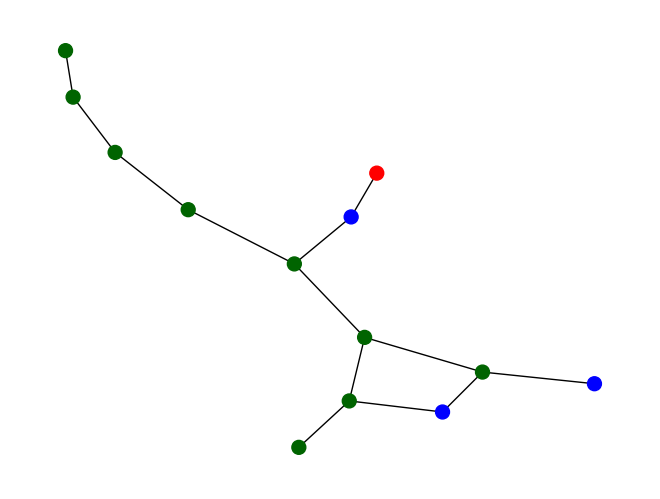

In [38]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

Text(0, 0.5, 'Density')

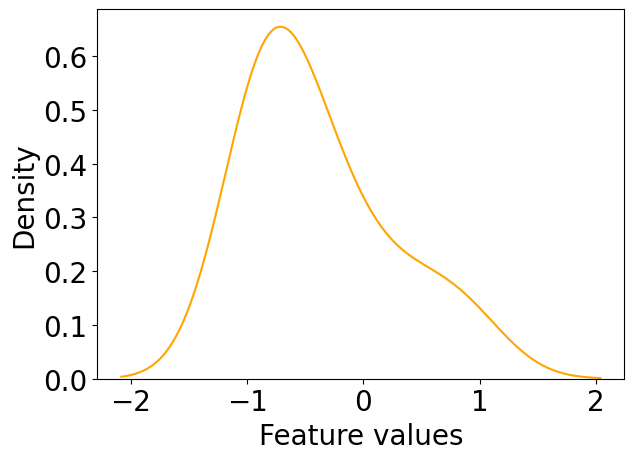

In [121]:
ind = index_2d(softmax_dict[class0_graphid], max_pred0)[0]
disease0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['disease'].numpy()[ind])
#plot_node_feat(disease0_df)
fig, ax = plt.subplots(figsize=(6.8,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(disease0_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [130]:
print_stat_cont_features(disease0_df)

mean -0.38354594
std dev 0.61506253


Number of nodes:  29
graph id:  119
Max pred probability for class 1 is 8.026680734474212e-05


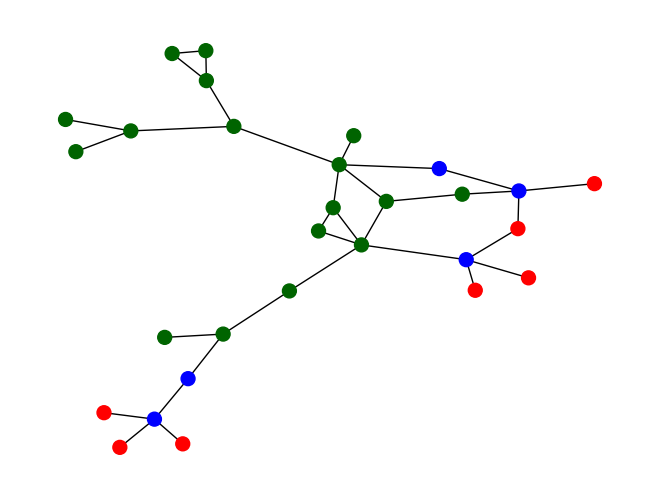

In [91]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

Text(0, 0.5, 'Density')

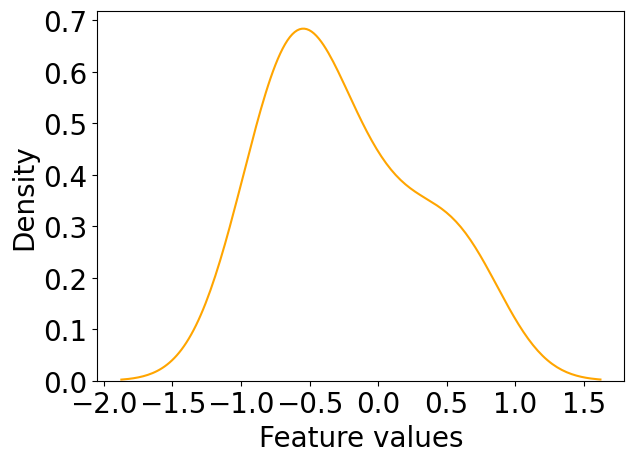

In [120]:
ind = index_2d(softmax_dict[class1_graphid], max_pred1)[0]
disease1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['disease'].numpy()[ind])
#plot_node_feat(disease1_df)
fig, ax = plt.subplots(figsize=(6.8,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(disease1_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [131]:
print_stat_cont_features(disease1_df)

mean -0.24495144
std dev 0.5342859


Number of nodes:  13
graph id:  52
Max pred probability for class 2 is 0.7704800963401794


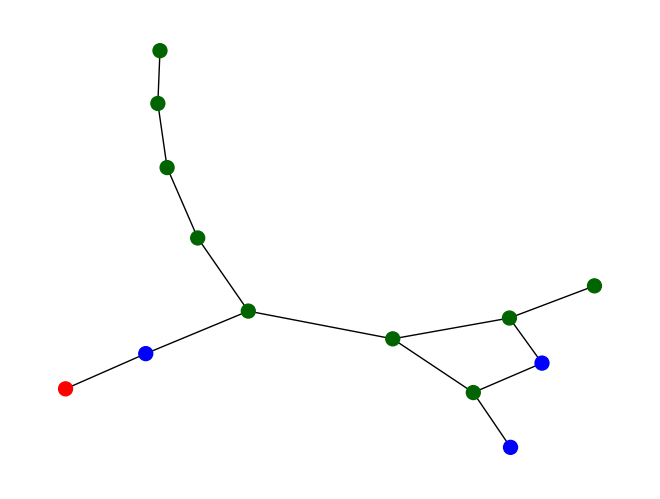

In [90]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

Text(0, 0.5, 'Density')

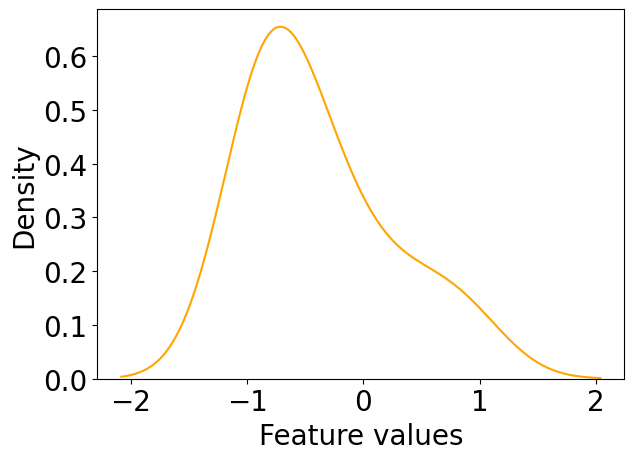

In [122]:
ind = index_2d(softmax_dict[class2_graphid], max_pred2)[0]
disease2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['disease'].numpy()[ind])
#plot_node_feat(disease2_df)
fig, ax = plt.subplots(figsize=(6.8,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(disease2_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [132]:
print_stat_cont_features(disease2_df)

mean -0.38354594
std dev 0.61506253


Number of nodes:  23
graph id:  171
Max pred probability for class 3 is 0.37373265624046326


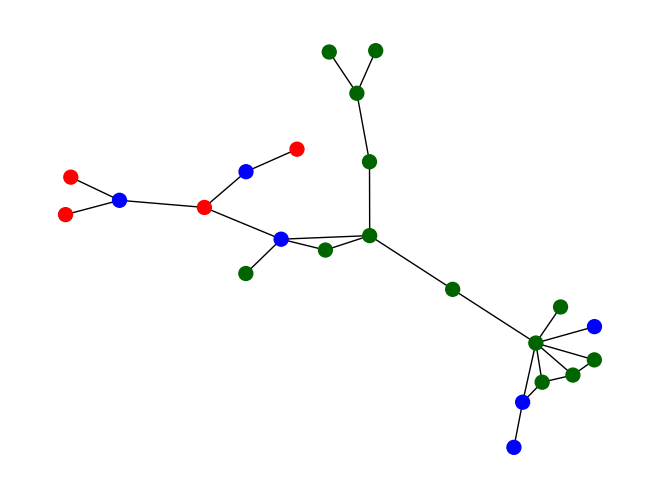

In [92]:
explanation_graph3 = plot_graph(class3_graphid, max_pred3, 3, all_edges[class3_graphid],graph_dict[class3_graphid])

Text(0, 0.5, 'Density')

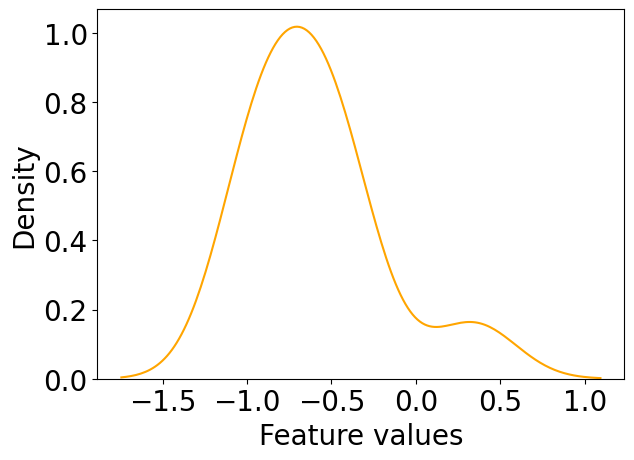

In [123]:
ind = index_2d(softmax_dict[class3_graphid], max_pred3)[0]
disease3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['disease'].numpy()[ind])
#plot_node_feat(disease2_df)
fig, ax = plt.subplots(figsize=(6.8,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(disease3_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [133]:
print_stat_cont_features(disease3_df)

mean -0.5991133
std dev 0.39605898


Number of nodes:  23
graph id:  171
Max pred probability for class 4 is 3.081552027439649e-11


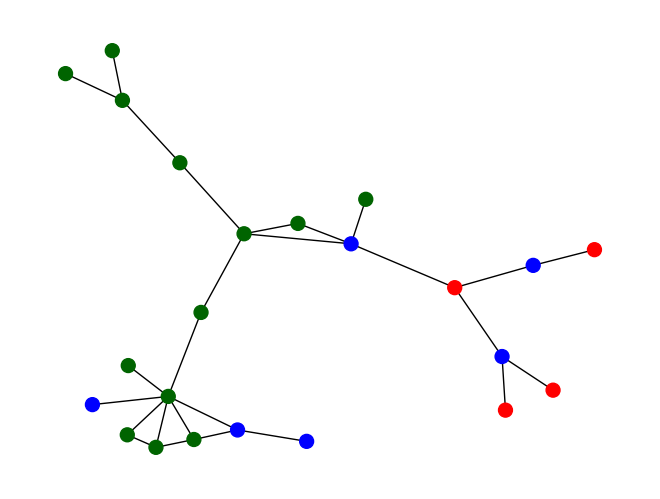

In [93]:
explanation_graph4 = plot_graph(class4_graphid, max_pred4, 4, all_edges[class4_graphid],graph_dict[class4_graphid])

Text(0, 0.5, 'Density')

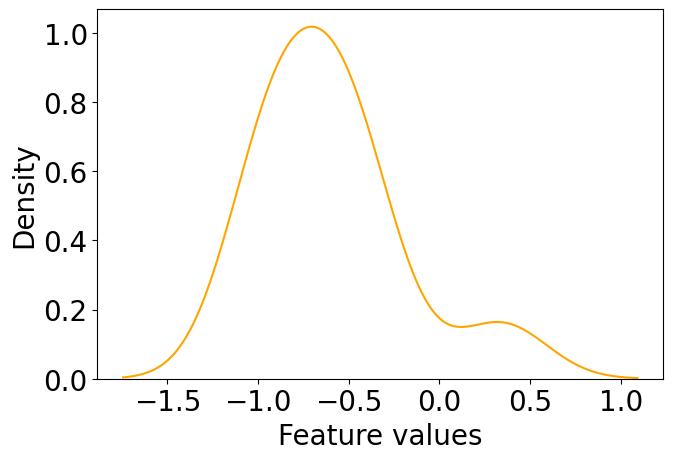

In [126]:
ind = index_2d(softmax_dict[class4_graphid], max_pred4)[0]
disease4_df = pd.DataFrame(nodefeature_dict[class4_graphid]['disease'].numpy()[ind])
#plot_node_feat(disease2_df)
fig, ax = plt.subplots(figsize=(7.3,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(disease4_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [134]:
print_stat_cont_features(disease4_df)

mean -0.5991133
std dev 0.39605898


Number of nodes:  11
graph id:  56
Max pred probability for class 5 is 1.0


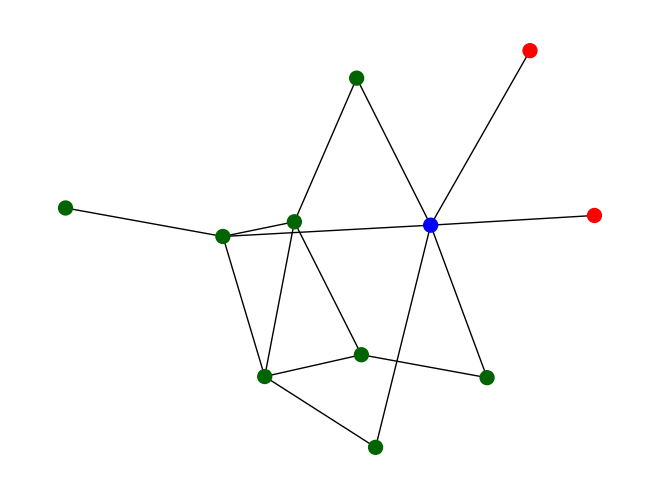

In [48]:
explanation_graph5 = plot_graph(class5_graphid, max_pred5, 5, all_edges[class5_graphid],graph_dict[class5_graphid])

Text(0, 0.5, 'Density')

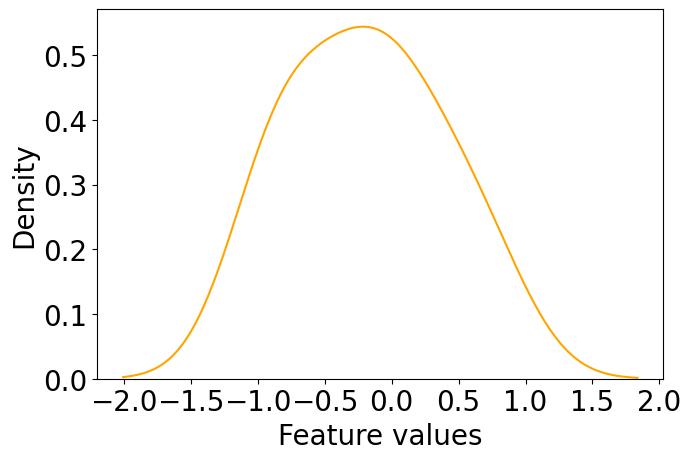

In [127]:
ind = index_2d(softmax_dict[class5_graphid], max_pred5)[0]
disease5_df = pd.DataFrame(nodefeature_dict[class5_graphid]['disease'].numpy()[ind])
#plot_node_feat(disease5_df)
fig, ax = plt.subplots(figsize=(7.3,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(disease5_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

Number of nodes:  23
graph id:  171
Max pred probability for class 6 is 0.002643890678882599


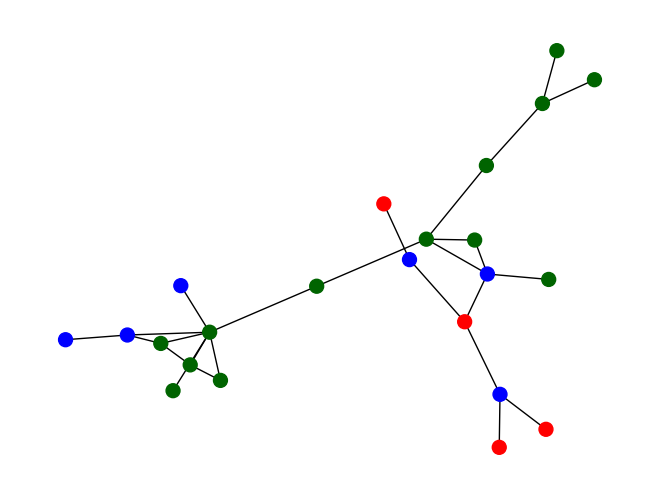

In [94]:
explanation_graph6 = plot_graph(class6_graphid, max_pred6, 6, all_edges[class6_graphid],graph_dict[class6_graphid])

Text(0, 0.5, 'Density')

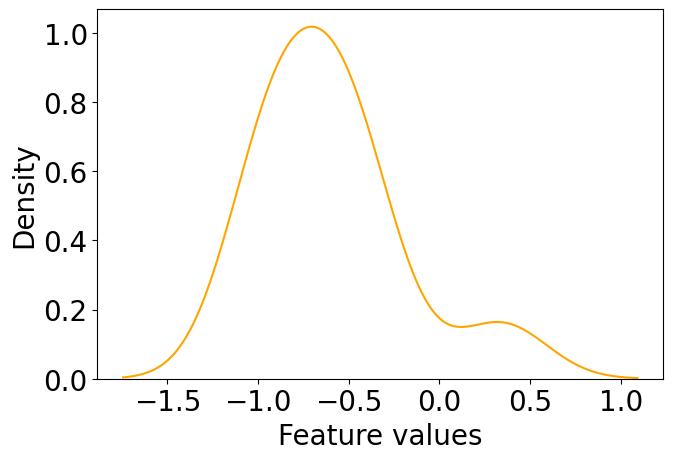

In [128]:
ind = index_2d(softmax_dict[class6_graphid], max_pred6)[0]
disease6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['disease'].numpy()[ind])
#plot_node_feat(disease5_df)
fig, ax = plt.subplots(figsize=(7.3,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(disease6_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

Number of nodes:  23
graph id:  171
Max pred probability for class 7 is 0.0017774914158508182


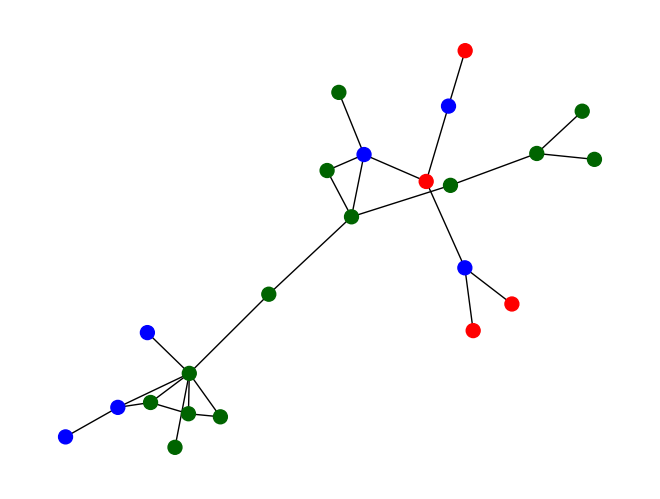

In [97]:
explanation_graph7 = plot_graph(class7_graphid, max_pred7, 7, all_edges[class7_graphid],graph_dict[class7_graphid])

Text(0, 0.5, 'Density')

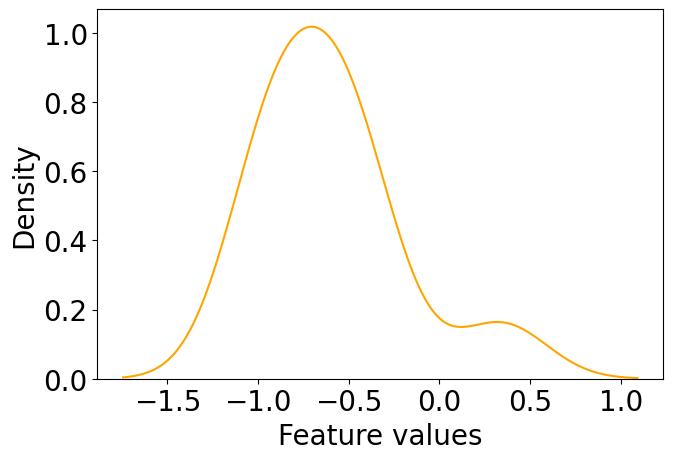

In [129]:
ind = index_2d(softmax_dict[class7_graphid], max_pred7)[0]
disease7_df = pd.DataFrame(nodefeature_dict[class7_graphid]['disease'].numpy()[ind])
#plot_node_feat(disease5_df)
fig, ax = plt.subplots(figsize=(7.3,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(disease7_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [54]:
#Gene Feature Statistics
gene0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['gene'].numpy())
print_stat_cont_features(gene0_df)

mean -0.4255304
std dev 0.39100206


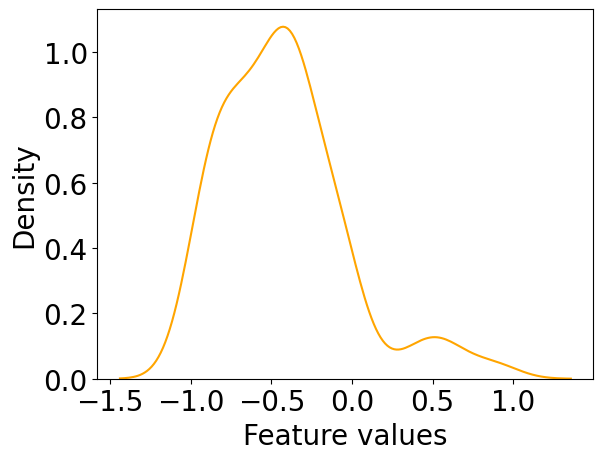

In [56]:
plot_node_feat(gene0_df)

In [57]:
gene1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['gene'].numpy())
print_stat_cont_features(gene1_df)

mean -0.49891934
std dev 0.33039922


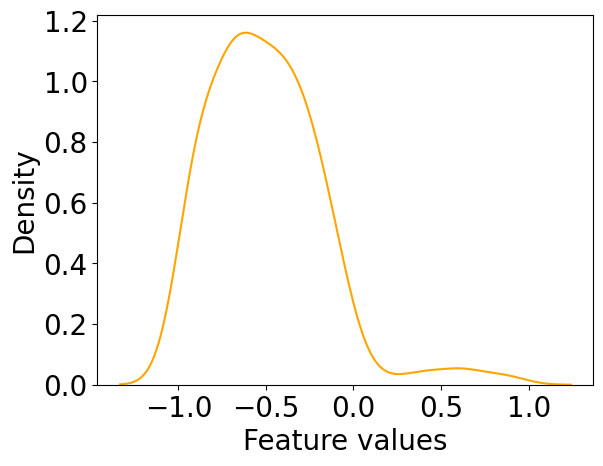

In [58]:
plot_node_feat(gene1_df)

In [59]:
gene2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['gene'].numpy())
print_stat_cont_features(gene2_df)

mean -0.4255304
std dev 0.39100206


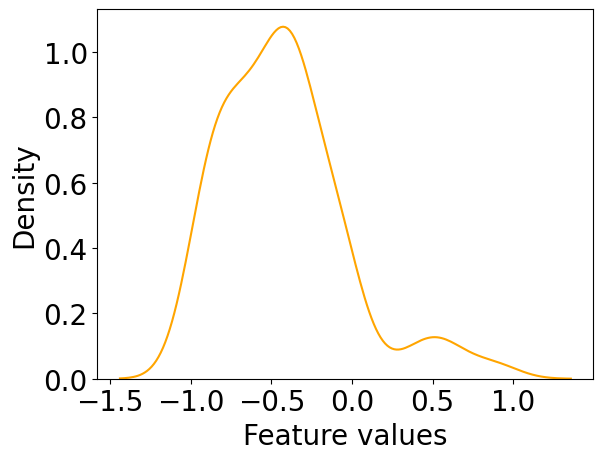

In [60]:
plot_node_feat(gene2_df)

In [61]:
gene3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['gene'].numpy())
print_stat_cont_features(gene3_df)

mean -0.34255564
std dev 0.42883113


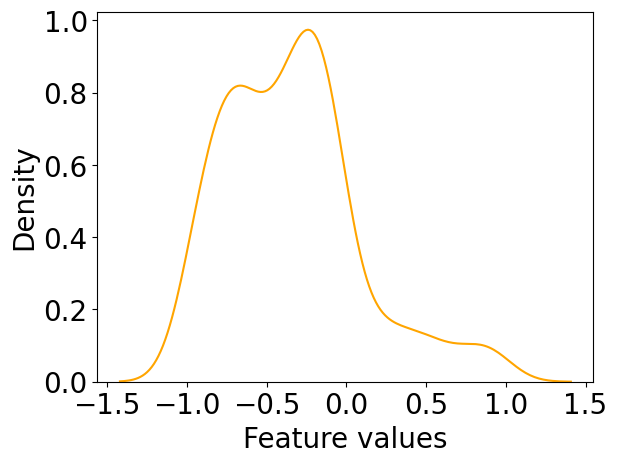

In [62]:
plot_node_feat(gene3_df)

In [63]:
gene4_df = pd.DataFrame(nodefeature_dict[class4_graphid]['gene'].numpy())
print_stat_cont_features(gene4_df)

mean -0.34255564
std dev 0.42883113


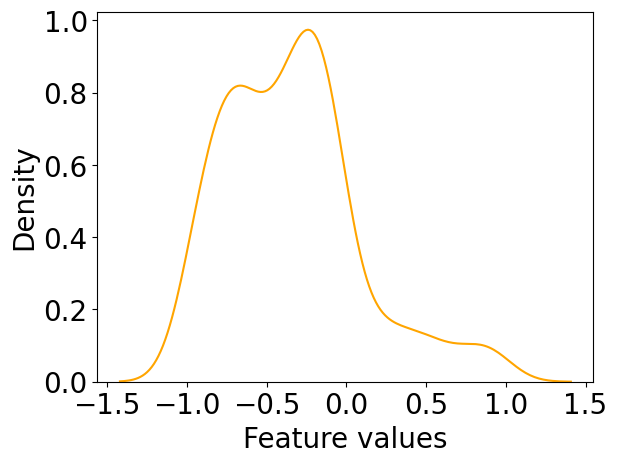

In [64]:
plot_node_feat(gene4_df)

In [65]:
gene5_df = pd.DataFrame(nodefeature_dict[class5_graphid]['gene'].numpy())
print_stat_cont_features(gene5_df)

mean -0.42735708
std dev 0.373073


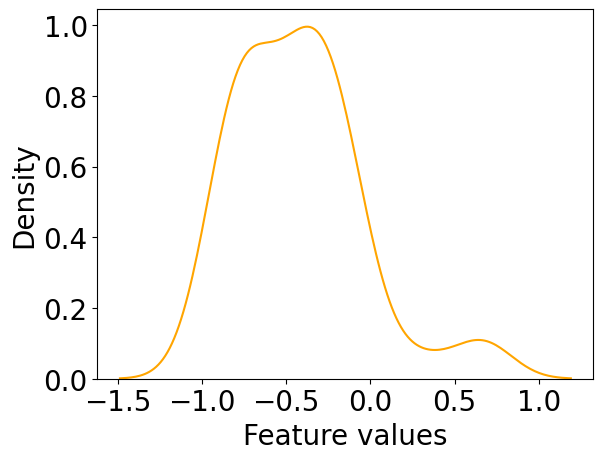

In [66]:
plot_node_feat(gene5_df)

In [67]:
gene6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['gene'].numpy())
print_stat_cont_features(gene6_df)

mean -0.34255564
std dev 0.42883113


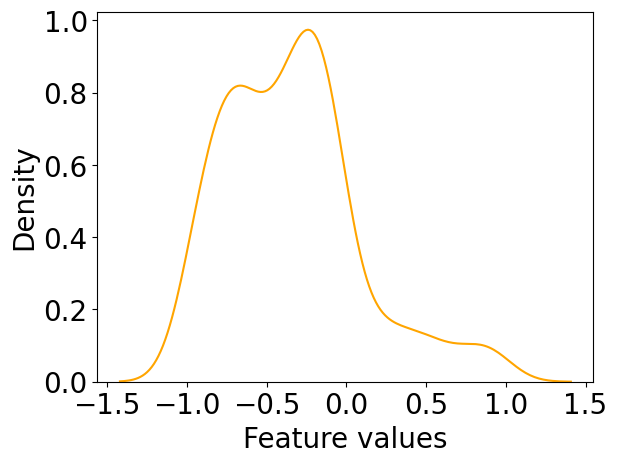

In [68]:
plot_node_feat(gene6_df)

In [69]:
gene7_df = pd.DataFrame(nodefeature_dict[class7_graphid]['gene'].numpy())
print_stat_cont_features(gene7_df)

mean -0.34255564
std dev 0.42883113


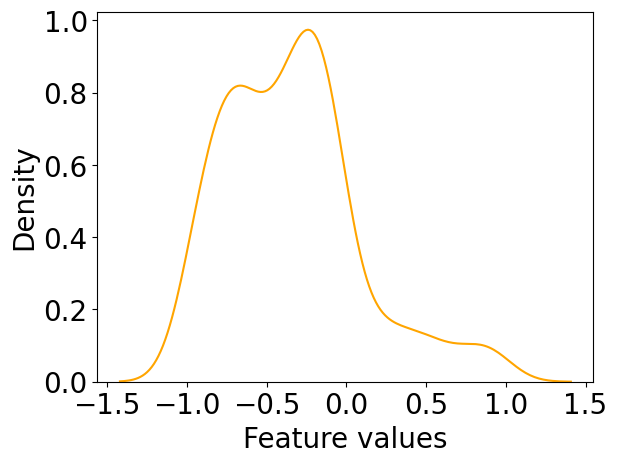

In [70]:
plot_node_feat(gene7_df)

In [71]:
#Chemical
chemical0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['chemical'].numpy())
print_stat_cont_features(chemical0_df)

mean -0.34574288
std dev 0.4690531


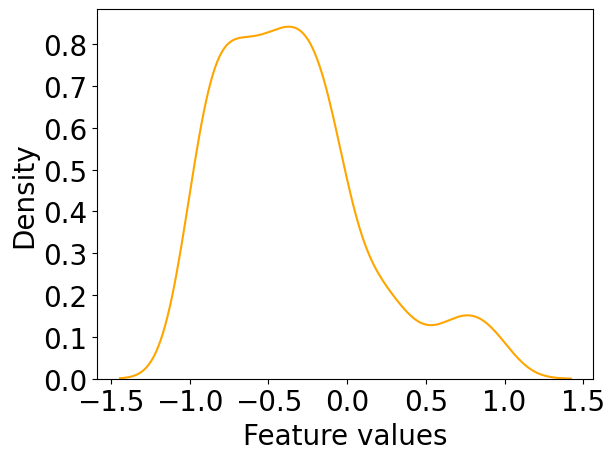

In [72]:
plot_node_feat(chemical0_df)

In [73]:
chemical1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['chemical'].numpy())
print_stat_cont_features(chemical1_df)

mean -0.36127344
std dev 0.44057938


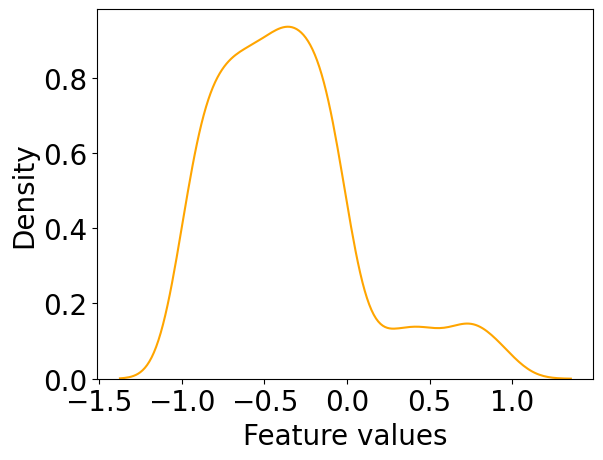

In [74]:
plot_node_feat(chemical1_df)

In [75]:
chemical2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['chemical'].numpy())
print_stat_cont_features(chemical2_df)

mean -0.34574288
std dev 0.4690531


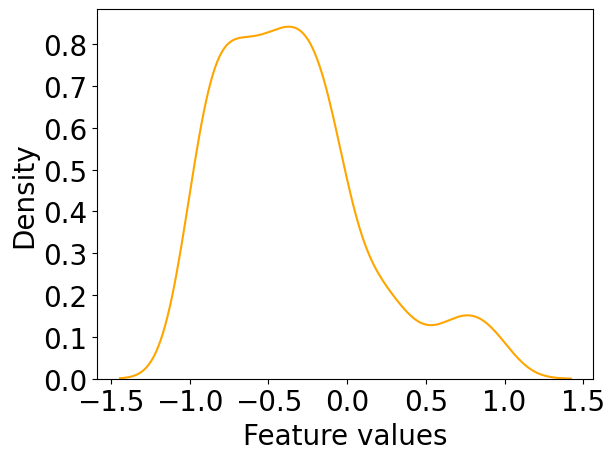

In [76]:
plot_node_feat(chemical2_df)

In [77]:
chemical3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['chemical'].numpy())
print_stat_cont_features(chemical3_df)

mean -0.35220444
std dev 0.47744766


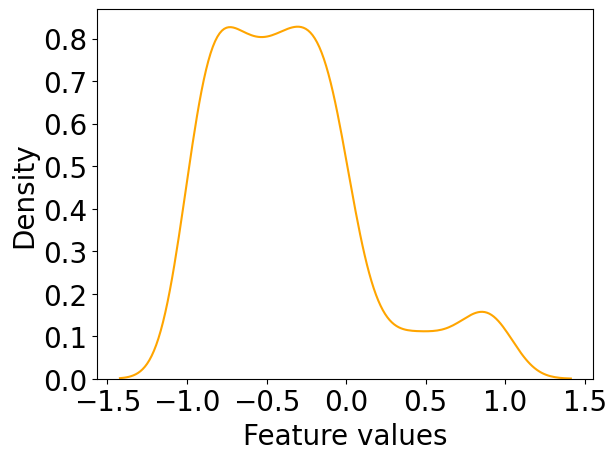

In [78]:
plot_node_feat(chemical3_df)

In [79]:
chemical4_df = pd.DataFrame(nodefeature_dict[class4_graphid]['chemical'].numpy())
print_stat_cont_features(chemical4_df)

mean -0.35220444
std dev 0.47744766


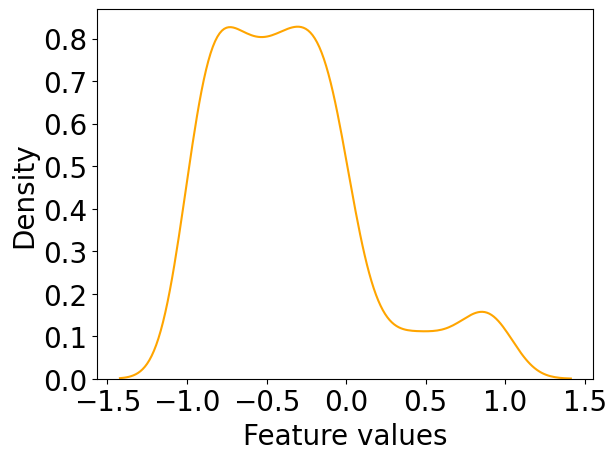

In [80]:
plot_node_feat(chemical4_df)

In [81]:
chemical5_df = pd.DataFrame(nodefeature_dict[class5_graphid]['chemical'].numpy())
print_stat_cont_features(chemical5_df)

mean -0.3652749
std dev 0.43963897


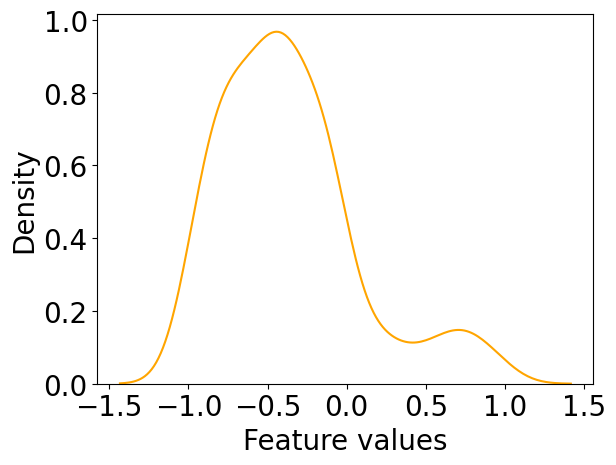

In [82]:
plot_node_feat(chemical5_df)

In [83]:
chemical6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['chemical'].numpy())
print_stat_cont_features(chemical6_df)

mean -0.35220444
std dev 0.47744766


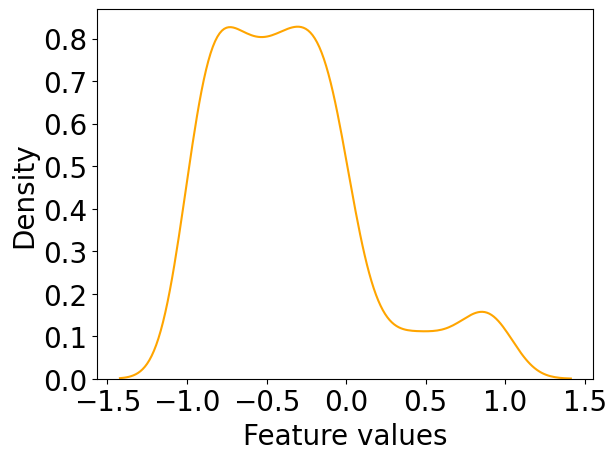

In [84]:
plot_node_feat(chemical6_df)

In [85]:
chemical7_df = pd.DataFrame(nodefeature_dict[class7_graphid]['chemical'].numpy())
print_stat_cont_features(chemical7_df)

mean -0.35220444
std dev 0.47744766


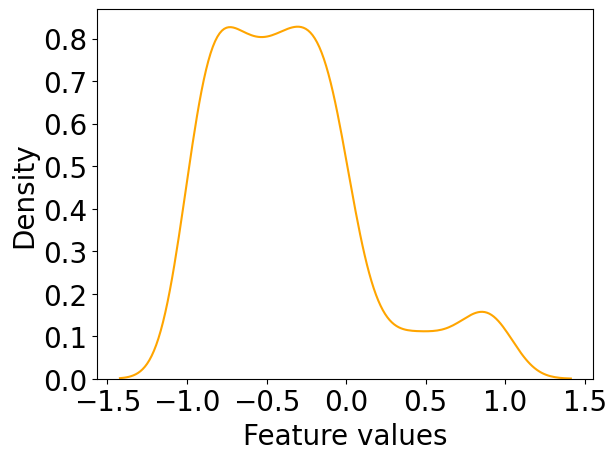

In [86]:
plot_node_feat(chemical7_df)